In [7]:
import matplotlib.pyplot as plt
import numpy as np
from formula import Formula
from formula import crossover_formulas
import random
plt.style.use('seaborn-v0_8')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore')

import scipy.stats # for finding statistical significance

import copy
import time

In [8]:
QUADRATIC_PATH = './data/quadratic_equation_full_details.csv'
LINEAR_PATH = './data/linear_equations_1_variable.csv'

## Graphing Functions
`plot_mean_and_bootstrapped_ci_over_time`: Plots the mean, bootstrapped 95% C.I over generational time

`plot_mean_over_time`: Plots the means over generational time

In [9]:
def plot_mean_and_bootstrapped_ci_over_time(input_data = None, name = "change me",
                                            x_label = "change me", y_label="change me",
                                            y_limit = None, plot_bootstrap = True):
    """
    
    parameters: 
    input_data: (numpy array of shape (max_k, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """
    num_generations = input_data.shape[1]
    num_runs = input_data.shape[0]
    
    # Make plotting the bootstrap optional!
    if plot_bootstrap:
        # confidence interval values need to be calculated separately for each generation

        # So, find the confidence interval over all of the repetitions (:) at each generation,
        # using [:,generation] 
        CIs = np.array([bootstrap.ci(data=input_data[:, generation])
                        for generation in range(num_generations)])
        # Creating np.arrays through list conversion is still a bit cheeky,
        # but it works fine and allows for better indexing (: and ,)

        # Take every generation's (:) lows (0)
        ci_low = CIs[:,0]
        # And take every generation's (:) highs (1)
        ci_high = CIs[:,1]

        plt.fill_between(range(num_generations), ci_low, ci_high, alpha=0.4)
    
    plt.plot(np.mean(input_data, axis=0), label = name)
    
    # Plot annotations
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(y_limit)
    plt.legend()

## Evolutionary Algorithms
`basic_evolutionary_algorithm': basic algorithm with truncation selection 

In [10]:
def basic_evolutionary_algorithm(degree = 2, min_len=5, max_len=25,path = None, total_generations=100, num_parents=10, num_children = 10, num_elements_to_mutate=1, num_crossover=2, crossover=True):
    """
    :param degree:  
    :param min_len: 
    :param max_len: 
    :param path: 
    :param total_generations: 
    :param num_parents: 
    :param num_children: 
    :param num_elements_to_mutate: 
    :param num_crossover: 
    :param crossover: 
    :return: 
    """
    #init record keeping
    solution = None
    solution_fitness = -999999
    fitness_over_time = []
    solution_over_time = []
    
    #init population
    Individuals = []
    for _ in range(num_parents):
        Individuals.append(Formula(min_len, max_len, degree, path))
    
    for i in range(total_generations):
        generation_fitnesses = []
        for ind in Individuals:
            generation_fitnesses.append(ind.eval_fitness()[0])
        fitness_over_time.append(np.max(generation_fitnesses))
        
        children = []
        while len(children) < num_children:
            parent_1, parent_2 = random.sample(Individuals, 2)
            child_1 = copy.deepcopy(parent_1)
            child_2 = copy.deepcopy(parent_2)
            #crossover
            if crossover:
                child_1.formula, child_2.formula = crossover_formulas(child_1, child_2, num_crossover)
            #mutation
            child_1.mutate_formula(num_elements_to_mutate)
            child_2.mutate_formula(num_elements_to_mutate)
            # add children to population
            children.append(child_1)
            if len(children) < num_children:
                children.append(child_2)
            Individuals.extend(children)
            Individuals.sort(key=lambda ind: ind.eval_fitness(), reverse=True)
            Individuals = Individuals[:num_parents]
            #update solutions over time
            solution_over_time.append(Individuals[-1].formula)
        if solution is None or Individuals[-1].eval_fitness() > solution_fitness:
            solution = Individuals[-1]
            solution_fitness = Individuals[-1].eval_fitness()
    Individuals[-1].pretty_print_formula()
    return fitness_over_time, solution_over_time, solution, solution_fitness
    
    


In [11]:
def tournament_evolutionary_algorithm(degree = 2, min_len=5, max_len=25,path = None, total_generations=100, num_parents=10, num_children = 10, num_elements_to_mutate=1, num_crossover=2, tournament_size = 10, tournament_winners = 2, crossover=True):
    """
    :param degree:  
    :param min_len: 
    :param max_len: 
    :param path: 
    :param total_generations: 
    :param num_parents: 
    :param num_children: 
    :param num_elements_to_mutate: 
    :param num_crossover: 
    :param crossover: 
    :return: 
    """
    #init record keeping
    solution = None
    solution_fitness = -999999
    fitness_over_time = []
    solution_over_time = []
    diversity_over_time = []
    
    #init population
    Individuals = []
    for _ in range(num_parents):
        Individuals.append(Formula(min_len, max_len, degree, path))
        
    for i in range(total_generations):
        generation_fitnesses = []
        for ind in Individuals:
            generation_fitnesses.append(ind.eval_fitness()[0])
        fitness_over_time.append(np.max(generation_fitnesses))
        # generate children
        children = []
        while len(children) < num_children:
            parent_1, parent_2 = random.sample(Individuals, 2)
            child_1 = copy.deepcopy(parent_1)
            child_2 = copy.deepcopy(parent_2)
            #crossover
            if crossover:
                child_1.formula, child_2.formula = crossover_formulas(child_1, child_2, num_crossover)
            #mutation
            child_1.mutate_formula(num_elements_to_mutate)
            child_2.mutate_formula(num_elements_to_mutate)
            # add children to population
            children.append(child_1)
            if len(children) < num_children:
                children.append(child_2)
            Individuals.extend(children)
        # tournament selection
        new_individuals = []
        while len(new_individuals) < num_parents:
            tournament_pool = []
            tournament_pool.extend(random.sample(Individuals, tournament_size))
            tournament_pool.sort(key=lambda individual: ind.eval_fitness(), reverse=True)
            new_individuals.extend(tournament_pool[:tournament_winners])
        # update individuals
        Individuals = new_individuals
        #update solutions over time
        solution_over_time.append(Individuals[-1].formula)
        if solution is None or Individuals[-1].eval_fitness() > solution_fitness:
            solution = Individuals[-1]
            solution_fitness = Individuals[-1].eval_fitness()
        
    solution.pretty_print_formula()
    return fitness_over_time, solution_over_time, solution, solution_fitness

In [12]:
def age_fitness_pareto_evolution(degree = 2, min_len=5, max_len=25,path = None, total_generations=100, num_parents=10, num_children = 10, num_elements_to_mutate=1, num_crossover=2, crossover=True, age_select_prop = 0.50):
    """
    :param degree:  
    :param min_len: 
    :param max_len: 
    :param path: 
    :param total_generations: 
    :param num_parents: 
    :param num_children: 
    :param num_elements_to_mutate: 
    :param num_crossover: 
    :param crossover: 
    :return: 
    """
    #init record keeping
    solution = None
    solution_fitness = -999999
    fitness_over_time = []
    solution_over_time = []
    
    #init population
    Individuals = []
    for _ in range(num_parents):
        Individuals.append(Formula(min_len, max_len, degree, path))
    
    for i in range(total_generations):
        generation_fitnesses = []
        for ind in Individuals:
            ind.increment_age() # incrememnt age with new generation
            generation_fitnesses.append(ind.eval_fitness()[0])
        fitness_over_time.append(np.max(generation_fitnesses))
        
        children = []
        while len(children) < num_children:
            parent_1, parent_2 = random.sample(Individuals, 2)
            child_1 = copy.deepcopy(parent_1)
            child_2 = copy.deepcopy(parent_2)
            #crossover
            if crossover:
                child_1.formula, child_2.formula = crossover_formulas(child_1, child_2, num_crossover)
            #mutation
            child_1.mutate_formula(num_elements_to_mutate)
            child_2.mutate_formula(num_elements_to_mutate)
            # add children to population
            children.append(child_1)
            if len(children) < num_children:
                children.append(child_2)
            Individuals.extend(children)
            #selection procedure (fitness)
            
            age_cutoff_group = round(age_select_prop * num_parents) 
            
            Individuals.sort(key=lambda ind: ind.eval_fitness(), reverse=True)
            Individuals = Individuals[:num_parents]
            
            #sort by age
            # trim selected group based on age and replace with new random individuals
            Individuals.sort(key=lambda ind: ind.get_age(), reverse=True)
            Individuals = Individuals[:age_cutoff_group]
            while len(Individuals) < num_parents:
                Individuals.append(Formula(min_len, max_len, degree, path))
            
            #update solutions over time
            solution_over_time.append(Individuals[-1].formula)
        if solution is None or Individuals[-1].eval_fitness() > solution_fitness:
            solution = Individuals[-1]
            solution_fitness = Individuals[-1].eval_fitness()
    Individuals[-1].pretty_print_formula()
    return fitness_over_time, solution_over_time, solution, solution_fitness
    

In [13]:
experiment_results = {}
solutions_results = {}

In [14]:

num_runs = 5
total_generations = 100
path = './data/quadratic_equation_full_details.csv'
degree = 2
min_len = 5
max_len = 25
num_elements_to_mutate = 1
num_parents = 10
num_children = 10
num_crossover = 2
tournament_size = 10
tournament_winners = 2

# tournament_size = 20
# num_tournament_winners = 10

crossover = True


experiment = 'tournament_1'

experiment_results[experiment] = np.zeros([num_runs, total_generations])
solutions_results[experiment] = {}

for run in range(num_runs):
    fitness, solution, _,_ = tournament_evolutionary_algorithm(degree,
                                                                min_len,
                                                                max_len,
                                                                path,
                                                                total_generations,
                                                                num_parents,
                                                                num_children,
                                                                num_elements_to_mutate,
                                                                num_crossover,
                                                               tournament_size,
                                                               tournament_winners,
                                                                crossover)
    experiment_results[experiment][run] = fitness
    solutions_results[experiment][run] = solution


 ((5*(c/a))/(((4**3)**4)-5)) 

 ((4-5)/(2 root 4)) 

 (a/((5*b)+3)) 

 ((2/4)*(2/b)) 

 ((4/(4**5))**4) 


In [15]:
num_runs = 5
total_generations = 100
path = './data/quadratic_equation_full_details.csv'
degree = 2
min_len = 5
max_len = 25
num_elements_to_mutate = 1
num_parents = 10
num_children = 10
num_crossover = 2

# tournament_size = 20
# num_tournament_winners = 10

crossover = True


experiment = 'trial 1'

experiment_results[experiment] = np.zeros([num_runs, total_generations])
solutions_results[experiment] = {}

for run in range(num_runs):
    fitness, solution, _,_ = basic_evolutionary_algorithm(degree,
                                                                min_len,
                                                                max_len,
                                                                path,
                                                                total_generations,
                                                                num_parents,
                                                                num_children,
                                                                num_elements_to_mutate,
                                                                num_crossover,
                                                                crossover)
    experiment_results[experiment][run] = fitness
    solutions_results[experiment][run] = solution


 (4/c) 

 (3-4) 

 ((4+3)/((((c+a)/b)-a)-(b+(3-b)))) 

 ((2/(4-b))+(((3**5)-((3**5)+3))/a)) 

 (2-3) 


In [20]:
num_runs = 5
total_generations = 100
path = './data/quadratic_equation_full_details.csv'
degree = 2
min_len = 5
max_len = 25
num_elements_to_mutate = 1
num_parents = 10
num_children = 10
num_crossover = 2
age_select_prop = 0.20

# tournament_size = 20
# num_tournament_winners = 10

crossover = True


experiment = 'pareto_1'

experiment_results[experiment] = np.zeros([num_runs, total_generations])
solutions_results[experiment] = {}

for run in range(num_runs):
    fitness, solution, _,_ = age_fitness_pareto_evolution(degree,
                                                                min_len,
                                                                max_len,
                                                                path,
                                                                total_generations,
                                                                num_parents,
                                                                num_children,
                                                                num_elements_to_mutate,
                                                                num_crossover,
                                                                crossover,
                                                                age_select_prop)
    experiment_results[experiment][run] = fitness
    solutions_results[experiment][run] = solution

(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')

 (((4+((4 root 3) root 3))-((4 root 3) root 3))*((b/((4+((4 root 3) root 3))*(a/c)))-4)) 

 (((a**3)/3)/3) 

 ((3**4)-(a-((5*(c/4))-(b-c)))) 

(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')

 ((b+c)+((2*4)**4)) 

(34, 'Result too large')
(34, 'Result too large')
(34, 'Result too large')
(34, 'Re

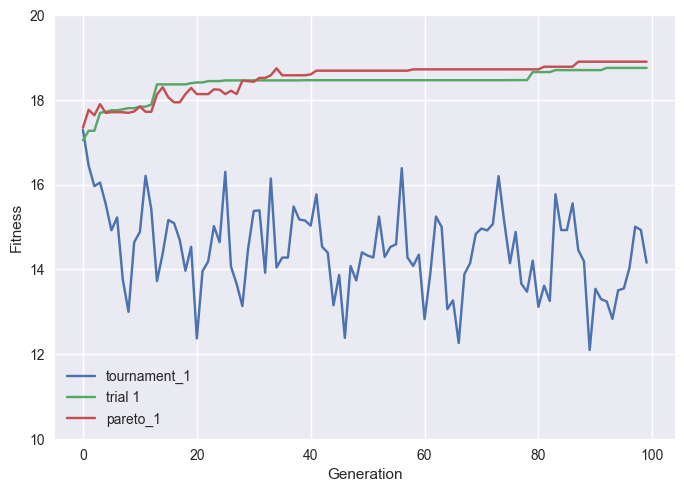

In [21]:
# plot fitness over time
# plotting
plt.figure(1, clear = True)
for experiment in experiment_results.keys():
    
    plot_mean_and_bootstrapped_ci_over_time(experiment_results[experiment],
                                            experiment,
                                            "Generation",
                                            "Fitness",
                                            [10,20],
                                            plot_bootstrap = False)
plt.show()